In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sympy.physics.units as u
import sympy as sp
import numpy as np
import logging as log
import functools
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
pd.set_option('display.max_columns', None)
%matplotlib inline
from IPython.display import display, HTML

import sys, os, importlib
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import miptlabs as ml
importlib.reload(ml)

importlib.reload(log)
log.basicConfig(level=log.INFO, format='LOG %(message)s', stream=sys.stdout)

sp.Basic.__str__=lambda expr, **settings:ml.PQStrPrinter(settings).doprint(expr)

sp.__version__

'1.1.2.dev'

In [3]:
# Эта лаба не сходится на 8 порядков. Кажется, там формулы неправильные.
data = pd.read_csv('1.1-1.3.csv')
display(data)

,x_m-,y_m-,x_m+,y_m+,K_x,K_y,V,x_m+.1,y_m+.1,K_x.1,K_y.1,V.1
0,-2.0,-1.8,2.2,1.6,1.00,5.00,102.0,4.0,3.0,20.0,500.0,20.0
1,-2.0,-1.8,2.2,1.6,1.00,5.00,90.5,3.0,2.7,20.0,500.0,18.0
2,-1.8,-1.8,2.1,1.6,1.00,5.00,80.0,4.8,2.5,10.0,500.0,16.0
3,-1.7,-1.8,2.0,1.6,1.00,5.00,70.0,4.0,2.2,10.0,500.0,14.0
4,-1.6,-1.8,1.8,1.6,1.00,5.00,60.0,3.4,1.9,10.0,500.0,12.0
5,-2.8,-1.8,3.0,1.6,0.50,5.00,50.5,2.6,4.0,10.0,200.0,10.0
6,-2.4,-1.8,2.4,1.2,0.50,5.00,40.0,4.3,3.2,5.0,200.0,8.0
7,-4.0,-2.0,5.0,1.4,0.20,2.00,30.0,3.4,2.4,5.0,200.0,6.0
8,-2.6,-2.8,3.4,2.0,0.20,0.10,20.5,2.3,3.2,5.0,100.0,4.0
9,-2.8,-1.4,3.4,1.4,0.20,0.02,10.0,NaN,NaN,NaN,NaN,NaN


In [4]:
# пункт 19
V = ml.PQ(54.8*u.v, sigma=0.5*u.v)
x_m, y_m=(-1.4, -1.8)
x_m, y_m=(1.8, 1.5)

In [5]:
#Ферромагнетик
df2 = pd.DataFrame()
df2['+V_x'] = ml.get_column(data, 'x_m+.1', lambda row: ml.PQ(row['x_m+.1']*row['K_x.1']*u.V, sigma=0.2*row['K_x.1']*u.V))
df2['+V_y'] = ml.get_column(data, 'y_m+.1', lambda row: ml.PQ(row['y_m+.1']*row['K_y.1']*u.V, sigma=0.2*row['K_y.1']*u.V))
#df1['V'] = ml.get_column(data, 'x_m-', lambda row: ml.PQ(row['x_m-']*row['K_x'], sigma=0.2))
display(df2)

,+V_x,+V_y
0,80±4 V (5.0%),1500±100 V (6.7%)
1,60±4 V (6.7%),1350±100 V (7.4%)
2,48.0±2.0 V (4.2%),1250±100 V (8.0%)
3,40.0±2.0 V (5.0%),1100±100 V (9.1%)
4,34.0±2.0 V (5.9%),950±100 V (11%)
5,26.0±2.0 V (7.7%),800±40 V (5.0%)
6,21.5±1.0 V (4.7%),640±40 V (6.2%)
7,17.0±1.0 V (5.9%),480±40 V (8.3%)
8,11.5±1.0 V (8.7%),320±20 V (6.2%)


B_r (-1.9±0.5)*10^-6 F*V*ohm/cm**2 (26%)
H_c 10.5±2.4 V/(cm*ohm) (23%)


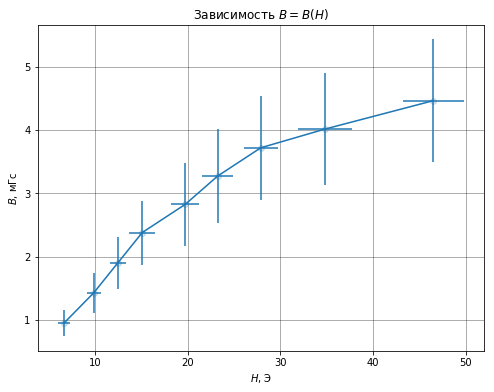

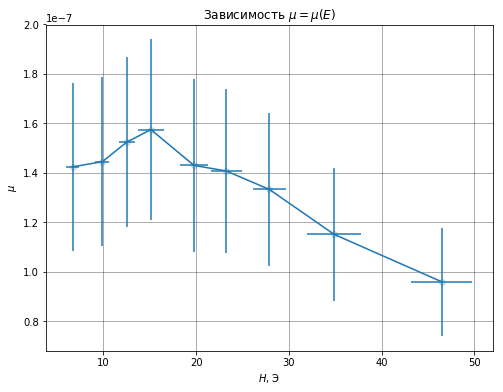

mu_max (9.60±2.20)*10^-8 F*ohm**2/cm (23%)


In [6]:
N_1 = 100
N_2 = 200
R_1 = ml.PQ(51*u.ohm, epsilon=0.05)
R_2 = ml.PQ(4.3*1e3*u.ohm, epsilon=0.05)
C = ml.PQ(0.22*1e-6*u.farad, epsilon=0.2).repr_as(u.farad)
d = ml.PQ(5*u.mm, is_const=True)
d_1 = ml.PQ(18*u.mm, is_const=True)
d_2 = ml.PQ(9*u.mm, is_const=True)
r_1 = d_1/2
r_2 = d_2/2
r_t = ((r_1+r_2)/2).repr_as(u.cm)
S = (np.pi*((r_1-r_2)/2)**2).repr_as(u.cm**2)

H_mult = 1e-1*(2*N_1)/(r_t*R_1)
df2['H'] = df2['+V_x']*H_mult
B_mult=1e2*(R_2*C*1e-6)/(N_2*S)
df2['B'] = df2['+V_y']*B_mult

x_c = -0.9
y_r = 1.3
U_r=ml.PQ(-y_r*data['K_y.1'][0]*u.volt, sigma=0.2*data['K_y.1'][0]*u.volt)
B_r=U_r*B_mult
U_c=ml.PQ(-x_c*data['K_x.1'][0]*u.volt, sigma=0.2*data['K_x.1'][0]*u.volt)
H_c=U_c*H_mult

print('B_r', B_r)
print('H_c', H_c)

plt.figure(figsize=(8, 6))
ml.plt_pq(df2['H'], df2['B']*1e6)
plt.title('Зависимость $B = B(H)$')
plt.xlabel('$H$, Э')
plt.ylabel('$B$, мГс')
plt.show()

plt.figure(figsize=(8, 6))
plt.title('Зависимость $\mu = \mu(E)$')
plt.xlabel('$H$, Э')
plt.ylabel('$\mu$')
ml.plt_pq(df2['H'], df2['B']/df2['H'])
plt.show()

mu_max = df2['B'][0]/df2['H'][0]
print('mu_max', mu_max)

#M_sat = (df2['B'][0]-df2['H'][0])/(4*np.pi)
#print('M_н', M_sat)

In [15]:
display(df2)
table_to_print2 = ml.prepare_to_print(df2)
display(table_to_print2)
ml.write_latex('table.tex', [ table_to_print2])

,+V_x,+V_y,H,B
0,80±4 V (5.0%),1500±100 V (6.7%),46±3 V/(cm*ohm) (7.1%),(4.5±1.0)*10^-6 F*V*ohm/cm**2 (22%)
1,60±4 V (6.7%),1350±100 V (7.4%),34.9±2.9 V/(cm*ohm) (8.3%),(4.0±0.9)*10^-6 F*V*ohm/cm**2 (22%)
2,48.0±2.0 V (4.2%),1250±100 V (8.0%),27.9±1.8 V/(cm*ohm) (6.5%),(3.7±0.8)*10^-6 F*V*ohm/cm**2 (22%)
3,40.0±2.0 V (5.0%),1100±100 V (9.1%),23.2±1.6 V/(cm*ohm) (7.1%),(3.3±0.7)*10^-6 F*V*ohm/cm**2 (23%)
4,34.0±2.0 V (5.9%),950±100 V (11%),19.8±1.5 V/(cm*ohm) (7.7%),(2.8±0.7)*10^-6 F*V*ohm/cm**2 (23%)
5,26.0±2.0 V (7.7%),800±40 V (5.0%),15.1±1.4 V/(cm*ohm) (9.2%),(2.4±0.5)*10^-6 F*V*ohm/cm**2 (21%)
6,21.5±1.0 V (4.7%),640±40 V (6.2%),12.5±0.9 V/(cm*ohm) (6.8%),(1.9±0.4)*10^-6 F*V*ohm/cm**2 (22%)
7,17.0±1.0 V (5.9%),480±40 V (8.3%),9.9±0.8 V/(cm*ohm) (7.7%),(1.4±0.3)*10^-6 F*V*ohm/cm**2 (22%)
8,11.5±1.0 V (8.7%),320±20 V (6.2%),6.7±0.7 V/(cm*ohm) (10%),(9.50±2.10)*10^-7 F*V*ohm/cm**2 (22%)


,"\thead{$+V_x$, \\ V}","\thead{$\sigma$($+V_x$), \\ V}","\thead{$\varepsilon$($+V_x$), \\ %}","\thead{$+V_y$, \\ V}","\thead{$\sigma$($+V_y$), \\ V}","\thead{$\varepsilon$($+V_y$), \\ %}","\thead{$H$, \\ V/(cm*ohm)}","\thead{$\sigma$($H$), \\ V/(cm*ohm)}","\thead{$\varepsilon$($H$), \\ %}","\thead{$B$, \\ $10^{-7}$F*V*ohm/cm**2}","\thead{$\sigma$($B$), \\ F*V*ohm/cm**2}","\thead{$\epsilon$($B$), \\ %}"
0,80.0,4.0,5.0,1500,100,6.7,46.48,3.29,7.1,44.60,9.70,22
1,60.0,4.0,6.7,1350,100,7.4,34.86,2.90,8.3,40.10,8.80,22
2,48.0,2.0,4.2,1250,100,8.0,27.89,1.82,6.5,37.20,8.20,22
3,40.0,2.0,5.0,1100,100,9.1,23.24,1.64,7.1,32.70,7.40,23
4,34.0,2.0,5.9,950,100,11,19.75,1.52,7.7,28.30,6.50,23
5,26.0,2.0,7.7,800,40,5.0,15.11,1.39,9.2,23.80,5.00,21
6,21.5,1.0,4.7,640,40,6.2,12.49,0.85,6.8,19.00,4.10,22
7,17.0,1.0,5.9,480,40,8.3,9.88,0.76,7.7,14.30,3.20,22
8,11.5,1.0,8.7,320,20,6.2,6.68,0.67,10,9.50,2.10,22


In [16]:
# Сегнетоэлектрик
df1 = pd.DataFrame()
df1['-V_x'] = ml.get_column(data, 'x_m-', lambda row: ml.PQ(row['x_m-']*row['K_x']*u.V, sigma=0.2*row['K_x']*u.V))
df1['-V_y'] = ml.get_column(data, 'y_m-', lambda row: ml.PQ(row['y_m-']*row['K_y']*u.V, sigma=0.2*row['K_y']*u.V))
df1['+V_x'] = ml.get_column(data, 'x_m+', lambda row: ml.PQ(row['x_m+']*row['K_x']*u.V, sigma=0.2*row['K_x']*u.V))
df1['+V_y'] = ml.get_column(data, 'y_m+', lambda row: ml.PQ(row['y_m+']*row['K_y']*u.V, sigma=0.2*row['K_y']*u.V))
df1['V'] = ml.get_column(data, 'V', lambda row: ml.PQ(row['V']*u.V, sigma=0.5*u.V))
df1 = df1.sort_values(by=['V'], ascending=False)
display(df1)

,-V_x,-V_y,+V_x,+V_y,V
0,-2.00±0.20 V (10%),-9.0±1.0 V (11%),2.20±0.20 V (9.1%),8.0±1.0 V (12%),102.0±0.5 V (0.49%)
1,-2.00±0.20 V (10%),-9.0±1.0 V (11%),2.20±0.20 V (9.1%),8.0±1.0 V (12%),90.5±0.5 V (0.55%)
2,-1.80±0.20 V (11%),-9.0±1.0 V (11%),2.10±0.20 V (9.5%),8.0±1.0 V (12%),80.0±0.5 V (0.62%)
3,-1.70±0.20 V (12%),-9.0±1.0 V (11%),2.00±0.20 V (10%),8.0±1.0 V (12%),70.0±0.5 V (0.71%)
4,-1.60±0.20 V (12%),-9.0±1.0 V (11%),1.80±0.20 V (11%),8.0±1.0 V (12%),60.0±0.5 V (0.83%)
12,-1.50±0.10 V (6.7%),-9.0±1.0 V (11%),1.70±0.10 V (5.9%),7.5±1.0 V (13%),55.0±0.5 V (0.91%)
5,-1.40±0.10 V (7.1%),-9.0±1.0 V (11%),1.50±0.10 V (6.7%),8.0±1.0 V (12%),50.5±0.5 V (0.99%)
11,-1.30±0.10 V (7.7%),-9.0±1.0 V (11%),1.40±0.10 V (7.1%),7.0±1.0 V (14%),45.0±0.5 V (1.1%)
6,-1.20±0.10 V (8.3%),-9.0±1.0 V (11%),1.20±0.10 V (8.3%),6.0±1.0 V (17%),40.0±0.5 V (1.2%)
7,-0.80±0.04 V (5.0%),-4.0±0.4 V (10%),1.00±0.04 V (4.0%),2.8±0.4 V (14%),30.0±0.5 V (1.7%)


D_r (12.70±1.40)*10^-9 F/cm**2 (11%)
E_c 0.052±0.005 1/cm (10%)


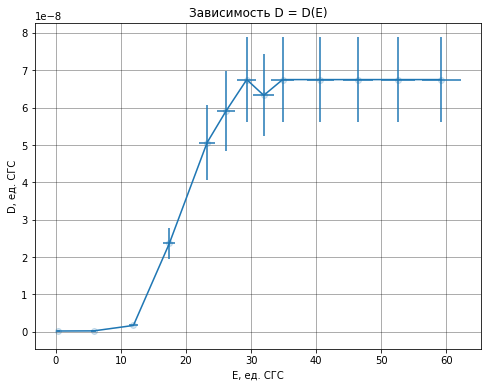

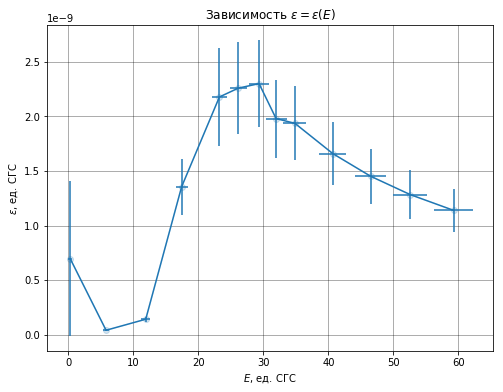

epsilon_max (5.4±0.9)*10^-9 F*V/cm**2 (17%)


In [17]:
h_1 = ml.PQ(1.0*u.mm, sigma=0.1*u.mm).repr_as(u.cm)
S = ml.PQ(6*3.5*u.mm**2, sigma=1.0*u.mm**2).repr_as(u.cm**2)
C_2 = ml.PQ(0.047*1e-6*u.farad, epsilon=0.1)
R_1 = ml.PQ(470*1e3*u.ohm, epsilon=0.05)
R_2 = ml.PQ(11*1e3*u.ohm, epsilon=0.05)

D_mult=12*np.pi*1e3*C_2*1e-6/S
#print(D_mult)
df1['D'] = df1['+V_y']*D_mult
E_mult=np.sqrt(2)/(300*h_1)
#print(E_mult)
df1['E'] = df1['V']*H_mult

y_r = 1.5
#y_r = -1.6
x_c = -1.1
#y_c = 1.3
D_r = y_r*D_mult
print('D_r', D_r)
E_c = -x_c*E_mult
print('E_c', E_c)

plt.figure(figsize=(8, 6))
plt.title('Зависимость D = D(E)')
plt.xlabel('E, ед. СГС')
plt.ylabel('D, ед. СГС')
ml.plt_pq(df1['E'], df1['D'])
plt.show()

plt.figure(figsize=(8, 6))
plt.title('Зависимость $\epsilon = \epsilon(E)$')
plt.xlabel('$E$, ед. СГС')
plt.ylabel('$\epsilon$, ед. СГС')
ml.plt_pq(df1['E'], df1['D']/df1['E'])
plt.show()

epsilon_max = df1['D'][0]/(4*np.pi)
print('epsilon_max', epsilon_max)

#P_sat = (df1['D']-df1['E'])/(4*np.pi)
#print('P_sat',P_sat)

In [20]:
display(df1)
table_to_print1 = ml.prepare_to_print(df1)
display(table_to_print1)
ml.write_latex('table.tex', [ table_to_print1, table_to_print2], horizontal=True)


,-V_x,-V_y,+V_x,+V_y,V,D,E
0,-2.00±0.20 V (10%),-9.0±1.0 V (11%),2.20±0.20 V (9.1%),8.0±1.0 V (12%),102.0±0.5 V (0.49%),(6.70±1.10)*10^-8 F*V/cm**2 (17%),59.3±3.0 V/(cm*ohm) (5.0%)
1,-2.00±0.20 V (10%),-9.0±1.0 V (11%),2.20±0.20 V (9.1%),8.0±1.0 V (12%),90.5±0.5 V (0.55%),(6.70±1.10)*10^-8 F*V/cm**2 (17%),52.6±2.6 V/(cm*ohm) (5.0%)
2,-1.80±0.20 V (11%),-9.0±1.0 V (11%),2.10±0.20 V (9.5%),8.0±1.0 V (12%),80.0±0.5 V (0.62%),(6.70±1.10)*10^-8 F*V/cm**2 (17%),46.5±2.3 V/(cm*ohm) (5.0%)
3,-1.70±0.20 V (12%),-9.0±1.0 V (11%),2.00±0.20 V (10%),8.0±1.0 V (12%),70.0±0.5 V (0.71%),(6.70±1.10)*10^-8 F*V/cm**2 (17%),40.7±2.1 V/(cm*ohm) (5.1%)
4,-1.60±0.20 V (12%),-9.0±1.0 V (11%),1.80±0.20 V (11%),8.0±1.0 V (12%),60.0±0.5 V (0.83%),(6.70±1.10)*10^-8 F*V/cm**2 (17%),34.9±1.8 V/(cm*ohm) (5.1%)
12,-1.50±0.10 V (6.7%),-9.0±1.0 V (11%),1.70±0.10 V (5.9%),7.5±1.0 V (13%),55.0±0.5 V (0.91%),(6.30±1.10)*10^-8 F*V/cm**2 (17%),32.0±1.6 V/(cm*ohm) (5.1%)
5,-1.40±0.10 V (7.1%),-9.0±1.0 V (11%),1.50±0.10 V (6.7%),8.0±1.0 V (12%),50.5±0.5 V (0.99%),(6.70±1.10)*10^-8 F*V/cm**2 (17%),29.3±1.5 V/(cm*ohm) (5.1%)
11,-1.30±0.10 V (7.7%),-9.0±1.0 V (11%),1.40±0.10 V (7.1%),7.0±1.0 V (14%),45.0±0.5 V (1.1%),(5.90±1.10)*10^-8 F*V/cm**2 (18%),26.1±1.3 V/(cm*ohm) (5.1%)
6,-1.20±0.10 V (8.3%),-9.0±1.0 V (11%),1.20±0.10 V (8.3%),6.0±1.0 V (17%),40.0±0.5 V (1.2%),(5.10±1.00)*10^-8 F*V/cm**2 (20%),23.2±1.2 V/(cm*ohm) (5.2%)
7,-0.80±0.04 V (5.0%),-4.0±0.4 V (10%),1.00±0.04 V (4.0%),2.8±0.4 V (14%),30.0±0.5 V (1.7%),(2.4±0.4)*10^-8 F*V/cm**2 (18%),17.4±0.9 V/(cm*ohm) (5.3%)


,"\thead{$-V_x$, \\ V}","\thead{$\sigma$($-V_x$), \\ V}","\thead{$\varepsilon$($-V_x$), \\ %}","\thead{$-V_y$, \\ V}","\thead{$\sigma$($-V_y$), \\ V}","\thead{$\varepsilon$($-V_y$), \\ %}","\thead{$+V_x$, \\ V}","\thead{$\sigma$($+V_x$), \\ V}","\thead{$\varepsilon$($+V_x$), \\ %}","\thead{$+V_y$, \\ V}","\thead{$\sigma$($+V_y$), \\ V}","\thead{$\varepsilon$($+V_y$), \\ %}","\thead{$V$, \\ V}","\thead{$\sigma$($V$), \\ V}","\thead{$\varepsilon$($V$), \\ %}","\thead{$D$, \\ $10^{-11}$F*V/cm**2}","\thead{$\sigma$($D$), \\ F*V/cm**2}","\thead{$\epsilon$($D$), \\ %}","\thead{$E$, \\ V/(cm*ohm)}","\thead{$\sigma$($E$), \\ V/(cm*ohm)}","\thead{$\varepsilon$($E$), \\ %}"
0,-2.000,0.200,10,-9.0000,1.0000,11,2.200,0.200,9.1,8.0000,1.0000,12,102.0,0.5,0.49,6749.90,1127.30,17,59.26,2.98,5.0
1,-2.000,0.200,10,-9.0000,1.0000,11,2.200,0.200,9.1,8.0000,1.0000,12,90.5,0.5,0.55,6749.90,1127.30,17,52.58,2.64,5.0
2,-1.800,0.200,11,-9.0000,1.0000,11,2.100,0.200,9.5,8.0000,1.0000,12,80.0,0.5,0.62,6749.90,1127.30,17,46.48,2.34,5.0
3,-1.700,0.200,12,-9.0000,1.0000,11,2.000,0.200,10,8.0000,1.0000,12,70.0,0.5,0.71,6749.90,1127.30,17,40.67,2.05,5.1
4,-1.600,0.200,12,-9.0000,1.0000,11,1.800,0.200,11,8.0000,1.0000,12,60.0,0.5,0.83,6749.90,1127.30,17,34.86,1.77,5.1
5,-1.500,0.100,6.7,-9.0000,1.0000,11,1.700,0.100,5.9,7.5000,1.0000,13,55.0,0.5,0.91,6328.10,1096.90,17,31.95,1.62,5.1
6,-1.400,0.100,7.1,-9.0000,1.0000,11,1.500,0.100,6.7,8.0000,1.0000,12,50.5,0.5,0.99,6749.90,1127.30,17,29.34,1.50,5.1
7,-1.300,0.100,7.7,-9.0000,1.0000,11,1.400,0.100,7.1,7.0000,1.0000,14,45.0,0.5,1.1,5906.20,1067.60,18,26.14,1.34,5.1
8,-1.200,0.100,8.3,-9.0000,1.0000,11,1.200,0.100,8.3,6.0000,1.0000,17,40.0,0.5,1.2,5062.50,1013.10,20,23.24,1.20,5.2
9,-0.800,0.040,5.0,-4.0000,0.4000,10,1.000,0.040,4.0,2.8000,0.4000,14,30.0,0.5,1.7,2362.50,427.10,18,17.43,0.92,5.3
